In [1]:
from __future__ import print_function
from fenics import *
import numpy as np
import dolfin as df
import os 
import matplotlib.pyplot as plt

# Create mesh and define function space

l = 1.0 
p0 = (0.0, 0.0, 0.0)
p1 = (l, l, 0.0)
nx = 20.0
ny = 20.0
nz = 1.0
#point source de chaleur
p2=(5., 5.)

mesh = BoxMesh(Point(0,0, 0), Point(0.3, 0.3, 0.3/20), 10, 10, 10, )

plot(mesh)


## donnees materiaux

In [2]:
#titane= Ta6V (titane+alu)
Eta= 115.E9   # module d'young Pa
rhota= 5000.   # kg/m^3
stressmaxta = 1.1E9   #Pa resistance à la traction
nuta=0.25   
lbdta=(nuta*Eta)/((1+nuta)*(1-2*nuta))  #Pa
cpvta=0.12  #(J/(m^3*K))
cpta= 550.   #J/(kg*K)
#contrainte max avant que ca casse

In [3]:
#acier
Eacier=210.E9
rhoacier= 7800.
nuacier=0.3
lbdacier=(nuacier*Eacier)/((1+nuacier)*(1-2*nuacier))
cpacier=  466.    #J/(kg*K)
cpvacier = 3.756E6   #J/(m^3*K)


In [4]:
#inconel
Einc=207.E9
rhoinc= 8470.
stressmaxinc = 600.E6   #Pa à 100°C
nuinc=0.3
lbdinc=(nuinc*Einc)/((1+nuinc)*(1-2*nuinc))
print(lbdinc)
cpinc=  496.    #J/(kg*K) à 100°C


119423076923.07692


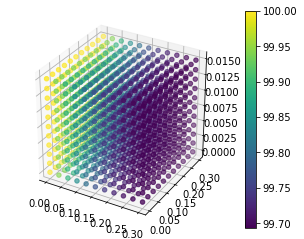

In [5]:
T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
#solution arbitraire
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)


class East(SubDomain):
    def inside(self, x , on_boundary):
       return near(x[1], 1.0)

class West(SubDomain):
    def inside(self, x , on_boundary):
       return near(x[1], 0.0)


class NoslipBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0] < DOLFIN_EPS )

class NoslipBoundary2(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and ( x[0] > 1.0 - DOLFIN_EPS) 
        
#class NoslipBoundary2(SubDomain):
#    def inside(self, x, on_boundary):
#        return on_boundary and (x[1] > 1.0 - DOLFIN_EPS or x[1] < DOLFIN_EPS) 

b_T = [DirichletBC(V, Constant(100.0), NoslipBoundary()), 
       DirichletBC(V, Constant(1.), NoslipBoundary2())] 


bcs = [DirichletBC(V, Constant(0), East()),
       DirichletBC(V, Constant(1), West())]

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)



# Time-stepping
u = Function(V)
t = 0 

for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, b_T)

    # Plot solution
    
    # Compute error at vertices
    u_e = interpolate(u_D, V) 
    # Update previous solution
    u_n.assign(u)
graph=plot(u)
#plt.colorbar(cax=x[0],0. , mappable, **kwargs)[source]
plt.colorbar(graph);

### Source ponctuelle

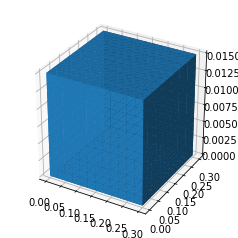

In [6]:
from dolfin import *
nbrnoeuds = 12
mesh2 = BoxMesh(Point(0,0, 0), Point(0.3, 0.3, 0.3/20.), nbrnoeuds, nbrnoeuds , nbrnoeuds)
plot(mesh2)

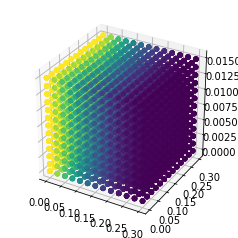

In [10]:
T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta
V = FunctionSpace(mesh2, 'P', 1)

# Define boundary condition
#solution arbitraire
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)


class East(SubDomain):
    def inside(self, x , on_boundary):
       return near(x[1], 1.0)

class West(SubDomain):
    def inside(self, x , on_boundary):
       return near(x[1], 0.0)


class NoslipBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0] < DOLFIN_EPS )

class NoslipBoundary2(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and ( x[0] > 1.0 - DOLFIN_EPS) 
        
#class NoslipBoundary2(SubDomain):
#    def inside(self, x, on_boundary):
#        return on_boundary and (x[1] > 1.0 - DOLFIN_EPS or x[1] < DOLFIN_EPS) 

b_T = [DirichletBC(V, Constant(100.0), NoslipBoundary()), 
       DirichletBC(V, Constant(1.), NoslipBoundary2())] 


bcs = [DirichletBC(V, Constant(0), East()),
       DirichletBC(V, Constant(1), West())]

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)


A, b = assemble_system(a, L, b_T)

delta = PointSource(V, Point(0.15,0.15,0.3/20), 1000)
delta.apply(b)


# Time-stepping
u = Function(V)
t = 0 

for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, b_T)

    # Plot solution
    
    # Compute error at vertices
    u_e = interpolate(u_D, V) 
    # Update previous solution
    u_n.assign(u)
    graph=plot(u)
   #plt.colorbar(graph);


##ne fonctionne pas mais utile

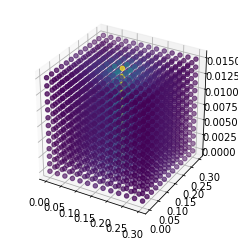

In [11]:
class NoslipBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0] < DOLFIN_EPS )

#dolfin_eps= eps tres petit comme d'hab
class NoslipBoundary2(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and ( x[0] > 1.0 - DOLFIN_EPS) 

b_T = [DirichletBC(V, Constant(1.), NoslipBoundary()), 
       DirichletBC(V, Constant(0.), NoslipBoundary2())] 

V = FunctionSpace(mesh2,"CG", 1)
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)


#a = inner(grad(u), grad(v))*dx
#L = Constant(0)*v*dx
A, l = assemble_system(a, L, b_T)

delta = PointSource(V, Point(0.15, 0.15,0.3/20), 1.)
delta.apply(l)

u = Function(V)

solve(A, u.vector(),l)
plot(u)

## Avec le temps

uqleuqe chose 4.000000000000001
0.0
0.013333333333333332
0.026666666666666665
0.04000000000000001
0.05333333333333333
0.06666666666666668
0.08
0.09333333333333332
0.10666666666666665
0.12000000000000001
0.13333333333333333
0.14666666666666664
0.16
0.17333333333333334
0.18666666666666668
0.20000000000000004
0.21333333333333337
0.2266666666666667
0.24000000000000007
0.2533333333333334


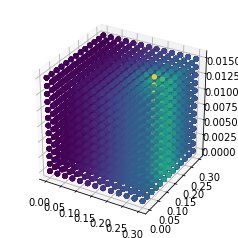

In [18]:
#for t in [ 0,2,4,6,8,10,12]:

class NoslipBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0] < DOLFIN_EPS )

#dolfin_eps= eps tres petit comme d'hab
class NoslipBoundary2(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and ( x[0] > 1.0 - DOLFIN_EPS) 

b_T = [DirichletBC(V, Constant(100.0), NoslipBoundary()), 
       DirichletBC(V, Constant(1.), NoslipBoundary2())] 

V = FunctionSpace(mesh2,"CG", 1)
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)
n_steps = 20
print("uqleuqe chose" ,t)
t=0.
for step in range(n_steps):
    
    x = (t/n_steps)*nbrnoeuds/9
    y = 0.15
    z = 0.3/20.

    #a = inner(grad(u), grad(v))*dx
    #L = Constant(0)*v*dx
    A, b = assemble_system(a, L, b_T)

     # Update current time
    t += dt
    print(x)
    #delta.set_point(t)
    #delta.apply(b)
    delta = PointSource(V, Point(x,y,z), 10.)
    delta.apply(b)

    u = Function(V)

    solve(A, u.vector(), b)
    plot(u)

In [19]:
#matplotlib notebook

V = FunctionSpace(mesh2, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

a = inner(grad(u), grad(v))*dx
L = Constant(0)*v*dx
bc = DirichletBC(V, Constant(0), DomainBoundary())
A, b = assemble_system(a, L, bc)

u = Function(V)
n_steps = 20
dt = 1./(4*n_steps)
t = 0

for step in range(n_steps):
   
    x = (t/n_steps)*nbrnoeuds
    y = 0.5
    z = 1.
    print(dt)
    print(t)
    print(x)
    print(y)
    print(step)
    print(n_steps)
#    cn = cos(2*pi*step*dt)
#    sn = sin(2*pi*step*dt)
#    den = (1 + sn**2)
#Point(0.5, 0.5,1.), 1.
    delta = PointSource(V, Point(x, y,z), 10.)
    delta.apply(b)
    solve(A, u.vector(), b)
    
    plot(u)
    t += dt
    # reset rhs
    b.zero()
    bc.apply(b) 

0.0125
0
0.0
0.5
0
20


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to apply point source to vector.
*** Reason:  The point is outside of the domain.
*** Where:   This error was encountered inside PointSource.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2018.1.0
*** Git changeset:  7afe9e1a24edb0e8d5ae51c3419fbb49f44d3d79
*** -------------------------------------------------------------------------


In [20]:
class NoslipBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0] < DOLFIN_EPS )

#dolfin_eps= eps tres petit comme d'hab
class NoslipBoundary2(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and ( x[0] > 1.0 - DOLFIN_EPS) 

b_T = [DirichletBC(V, Constant(1.), NoslipBoundary()), 
       DirichletBC(V, Constant(0.), NoslipBoundary2())] 

V = FunctionSpace(mesh2,"CG", 1)
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)


#a = inner(grad(u), grad(v))*dx
#L = Constant(0)*v*dx
A, l = assemble_system(a, L, b_T)

delta = PointSource(V, Point(0.5, 0.5,1.), 0.5)
delta.apply(l)

u = Function(V)

solve(A, u.vector(),l)
plot(u)

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to apply point source to vector.
*** Reason:  The point is outside of the domain.
*** Where:   This error was encountered inside PointSource.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2018.1.0
*** Git changeset:  7afe9e1a24edb0e8d5ae51c3419fbb49f44d3d79
*** -------------------------------------------------------------------------


/opt/fenics-2018.1/lib/python3.5/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'interactive'
  s)


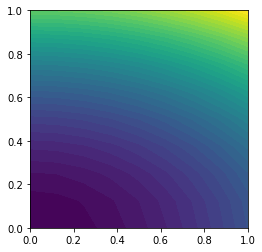

In [21]:
from fenics import *
import numpy as np

T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Time-stepping
u = Function(V)
t = 0
for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, bc)

    # Plot solution
    plot(u, interactive = True)

    # Compute error at vertices
   # u_e = interpolate(u_D, V)
   # error = np.abs(u_e.vector().array() - u.vector().array()).max()
   # print('t = %.2f: error = %.3g' % (t, error))

    # Update previous solution
    u_n.assign(u)

# Hold plot
#interactive()

In [22]:
## Vitesse faisceau : trop petite/forte 0.23 m/s ? donnees machines?